# Task2: Sentiment Analysis 

This notebook can be executed by uncommenting the commands in the first cell of the Imports section.

Training and fine tuning can take several hours depending on the hardware which is used. 

To skip these processes, you can download pretrained and fine tuned models here:
[Download Models](https://drive.google.com/drive/folders/1IkEtoGj3clHgxORdfFg6GHTekAR8A1TM?usp=sharing)

Make sure to locate them in the projects root inside the models directory like this:

```
root
├───models
```

## Introduction

Sentiment analysis of Yelp reviews using Natural Language Processing (NLP) models is an interesting area that combines language processing with machine learning to understand customer feelings. This project aims to compare several advanced NLP models like BERT, RoBERTa, and GPT to see how well they can classify Yelp reviews as positive, neutral, or negative. By adjusting these models, we hope to improve their performance and find out which model is the best in terms of accuracy, precision, and recall. This comparison will show the strengths and weaknesses of each model and suggest how fine-tuning can make them better, ultimately identifying the best model for sentiment analysis.

## Imports

The following commands make sure that the provided code can be executed on local environments.

It is recommended to set up a virtual environment with Anaconda or python-venv before installing these dependencies. 

In [1]:
#!pip install -r requirements.txt
#!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
#!pip install -U accelerate
#!pip install -U jupyter ipywidgets
#!python -m spacy download en_core_web_sm

**This setup prepares the environment for a sentiment analysis task, including data preprocessing, text cleaning, model training, evaluation, and visualization.**

> Imports various libraries and modules required for natural language processing (NLP), machine learning, and data visualization:

- **os, re, json, yaml**: Standard libraries for file operations, regular expressions, and data handling.
- **nltk**: NLP libraries for text processing.
- **torch**: Deep learning library.
- **optuna**: Hyperparameter optimization library.
- **logging**: For logging information.
- **numpy, pandas**: Libraries for numerical and data manipulation.
- **gradio**: For creating web interfaces.
- **plotly, matplotlib**: Libraries for data visualization.
- **transformers**: Library for NLP models and tokenizers.
- **wordcloud**: For generating word clouds.
- **collections.Counter**: For counting elements.
- **nltk.corpus.stopwords**: For removing stopwords.
- **torch.utils.data.Dataset**: For handling datasets in PyTorch.
- **sklearn.model_selection.train_test_split**: For splitting datasets.
- **sklearn.metrics**: For calculating evaluation metrics.

> Downloads necessary NLTK data (punkt and stopwords) and sets up the stopwords.

> Configures logging to display informational messages, and sets up a logger named 'Sentiment-Analysis'.

In [2]:
import os
import re
import time
import json
import yaml
import nltk
import torch
import optuna
import logging
import hashlib
import numpy as np
import gradio as gr
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from transformers import (
    AutoTokenizer,
    RobertaForSequenceClassification,
    DistilBertForSequenceClassification,
    ElectraForSequenceClassification,
    GPT2ForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from pprint import pformat
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('Sentiment-Analysis')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data

This part of the code is responsible for importing the training and testing datasets, which are essential for building and evaluating the sentiment analysis model.

In [3]:
# Load the data
train_df = pd.read_csv('./data/Sentiment_Training.csv', sep=';')
test_df = pd.read_csv('./data/Sentiment_Test.csv', sep=';')

### EDA

This EDA code provides a comprehensive overview of the dataset, including data inspection, text length analysis, label distribution and visualizations using word clouds. These steps help in understanding the dataset better and identifying any potential issues before model training.

In [4]:
logger.info("First few rows of the training dataset:")
train_df.head()

INFO:Sentiment-Analysis:First few rows of the training dataset:


,label,text
0,4,I stalk this truck. I've been to industrial p...
1,2,"who really knows if this is good pho or not, i..."
2,4,I LOVE Bloom Salon... all of their stylist are...
3,0,"We were excited to eat here, it is difficult t..."
4,2,"So this is a place, with food. That much canno..."


In [5]:
logger.info("Information about the training dataset:")
train_df.info()

INFO:Sentiment-Analysis:Information about the training dataset:


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   10000 non-null  int64 
 1   text    10000 non-null  object
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [6]:
# Calculate text length
train_df['text_length'] = train_df['text'].apply(len)
logger.info("Statistics of text lengths in the training dataset:")
train_df['text_length'].describe()

INFO:Sentiment-Analysis:Statistics of text lengths in the training dataset:


count    10000.000000
mean       729.239800
std        653.262897
min          2.000000
25%        283.000000
50%        544.000000
75%        968.000000
max       5015.000000
Name: text_length, dtype: float64

In [7]:
# Histogram of text lengths using Plotly
fig = px.histogram(train_df, x='text_length', nbins=50, title='Distribution of Text Lengths')
fig.update_layout(
    xaxis_title='Text Length',
    yaxis_title='Frequency',
    bargap=0.2
)
fig.show()

In [8]:
# Distribution of labels
logger.info("Distribution of labels in the training dataset:")
train_df['label'].value_counts().sort_index()

INFO:Sentiment-Analysis:Distribution of labels in the training dataset:


label
0    2035
1    1977
2    1943
3    1991
4    2054
Name: count, dtype: int64

In [9]:
# Plot of label distribution using Plotly
label_distribution = train_df['label'].value_counts().sort_index()
fig = px.bar(label_distribution, title='Distribution of Labels')
fig.update_layout(
    xaxis_title='Label',
    yaxis_title='Count',
    xaxis=dict(tickmode='linear')
)
fig.show()

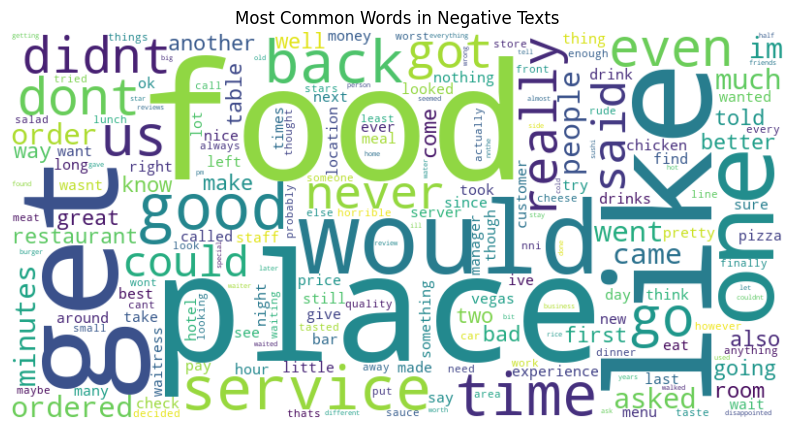

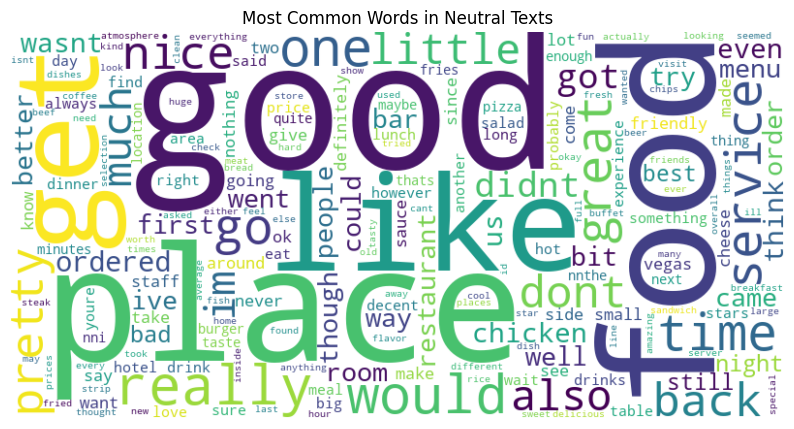

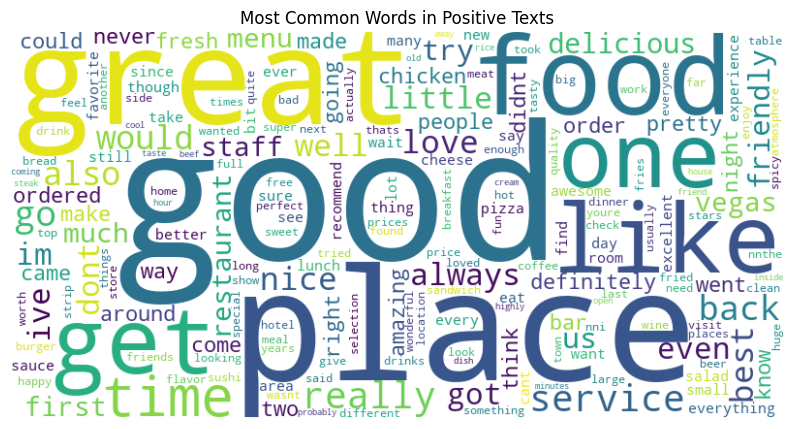

In [10]:
# Function to clean and tokenize text
def tokenize(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Set of NLTK stop words
stop_words = set(stopwords.words('english'))

# Function to generate word clouds for each category
def generate_wordcloud(words, title):
    word_counts = Counter(words)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
    
    # Plot WordCloud using Matplotlib
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Filter texts by label and tokenize
negative_texts = train_df[train_df['label'].isin([0, 1])]['text']
neutral_texts = train_df[train_df['label'] == 2]['text']
positive_texts = train_df[train_df['label'].isin([3, 4])]['text']

negative_words = negative_texts.apply(tokenize).sum()
neutral_words = neutral_texts.apply(tokenize).sum()
positive_words = positive_texts.apply(tokenize).sum()

# Generate word clouds for each category
generate_wordcloud(negative_words, 'Most Common Words in Negative Texts')
generate_wordcloud(neutral_words, 'Most Common Words in Neutral Texts')
generate_wordcloud(positive_words, 'Most Common Words in Positive Texts')

In [11]:
# Boxplot of text lengths by label using Plotly
fig = px.box(train_df, x='label', y='text_length', title='Text Lengths by Label')
fig.update_layout(
    xaxis_title='Label',
    yaxis_title='Text Length'
)
fig.show()

In [12]:
# Text lengths grouped by label and described
text_length_by_label = train_df.groupby('label')['text_length'].describe()

# Output text lengths by label
logger.info(f"Text lengths by label:")
text_length_by_label

INFO:Sentiment-Analysis:Text lengths by label:


,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,2035.0,815.115971,747.139814,2.0,302.50,579.0,1091.00,5015.0
1,1977.0,809.385432,704.992632,21.0,320.00,602.0,1075.00,5014.0
2,1943.0,763.033968,642.396337,7.0,322.50,597.0,1008.50,5011.0
3,1991.0,675.672526,560.609923,10.0,273.00,534.0,913.00,5003.0
4,2054.0,586.973223,560.745037,8.0,217.25,417.5,752.75,5009.0


### Preprocessing

This code snippet ensures that the text data is cleaned and standardized by removing extra whitespace and replacing abbreviations with their full forms. This preprocessing step improves the quality of the text data, making it more suitable for subsequent analysis and model training.

In [13]:
def text_preprocessing(text):
    """
    Preprocesses the input text by removing extra whitespace.

    Args:
        text (str): The input text to preprocess.

    Returns:
        str: The preprocessed text with extra whitespace removed.
    """
    # Remove extra whitespace and strip leading/trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply text preprocessing to the training and test datasets
train_df['text'] = train_df['text'].apply(text_preprocessing)
test_df['text'] = test_df['text'].apply(text_preprocessing)

# Load abbreviations from the YAML file
with open('./data/abbreviations.yaml', 'r') as file:
    abbreviations = yaml.safe_load(file)

def replace_abbreviations(text):
    """
    Replaces abbreviations in the input text with their full forms using a predefined dictionary.

    Args:
        text (str): The input text to process.

    Returns:
        str: The text with abbreviations replaced by their full forms.
    """
    for abbr, full_form in abbreviations.items():
        text = text.replace(abbr, full_form)
    return text

# Replace abbreviations in the training and test datasets
train_df['text'] = train_df['text'].apply(replace_abbreviations)
test_df['text'] = test_df['text'].apply(replace_abbreviations)

## Evaluation

### Device Setup

This part of the code sets up the computational device (GPU or CPU) for model training and inference, ensuring optimal performance based on the hardware capabilities available.

In [14]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    logger.info(f"\nUsing device: {torch.cuda.get_device_name(0)}")
else:
    logger.info("\nUsing CPU")

INFO:Sentiment-Analysis:
Using device: NVIDIA GeForce RTX 4080


### Models

This dictionary serves as a configuration to easily reference different transformer models and their corresponding classes, facilitating model loading and training in the sentiment analysis task.

In [15]:
model_names = {
    'DistilBERT': ('distilbert-base-uncased', DistilBertForSequenceClassification),
    'Electra': ('google/electra-base-discriminator', ElectraForSequenceClassification),
    'RoBERTa': ('roberta-base', RobertaForSequenceClassification),
    'GPT2': ('gpt2', GPT2ForSequenceClassification)
}

### Custom Dataset

This custom dataset class is used to handle the tokenized input data and labels, enabling efficient data loading and batching for training and evaluation in the sentiment analysis model.

In [16]:
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

### Evaluation Metrics

These functions ensure the dataset's label integrity, evaluate model performance with key metrics, and provide a visual summary of model accuracy through a confusion matrix.

In [17]:
def validate_labels(labels):
    unique_labels = set(labels)
    logger.info(f"Unique labels: {unique_labels}")
    assert all(label in [0, 1, 2, 3, 4] for label in unique_labels), "Labels are out of the expected range."

def compute_metrics(p):
    predictions = np.array(p.predictions)
    preds = np.argmax(predictions, axis=1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'eval_accuracy': accuracy,
        'eval_precision': precision,
        'eval_recall': recall,
        'eval_f1': f1
    }

def plot_confusion_matrix(labels, preds, model_name):
    conf_mat = confusion_matrix(labels, preds)
    num_classes = conf_mat.shape[0]
    
    # Dynamically generate the labels based on the number of classes
    x = [str(i) for i in range(num_classes)]
    y = [str(i) for i in range(num_classes)]
    
    z = conf_mat.tolist()
    z_text = [[str(y) for y in x] for x in z]

    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Blues')
    fig.update_layout(
        title_text=f'Confusion Matrix for {model_name}',
        xaxis=dict(title='Predicted Labels'),
        yaxis=dict(title='True Labels')
    )
    fig.show()

### Training and Optimization

These functions handle the complete process of training, evaluating, saving, loading, and optimizing models for sentiment analysis, ensuring that the best model is identified based on performance metrics.

In [18]:
def train_model(model_name, train_df, learning_rate=5e-5, batch_size=8, num_epochs=3, use_early_stopping=False, weight_decay=0.01, gradient_accumulation_steps=4, mode='standard'):
    """
    Trains a sentiment classification model.

    Args:
        model_name (str): The name of the model to be trained.
        train_df (pd.DataFrame): The training dataframe containing 'text' and 'label' columns.
        learning_rate (float): The learning rate for training. Default is 5e-5.
        batch_size (int): The batch size for training and evaluation. Default is 8.
        num_epochs (int): Number of training epochs. Default is 3.
        use_early_stopping (bool): Whether to use early stopping. Default is False.
        weight_decay (float): Weight decay to apply during training. Default is 0.01.
        gradient_accumulation_steps (int): Number of gradient accumulation steps. Default is 4.

    Returns:
        model: The trained model.
        tokenizer: The tokenizer used for the model.
        eval_results: Evaluation results of the model.
    """
    logger.info(f"Training model: {model_name}")

    # Load the tokenizer and model class based on the model name
    tokenizer = AutoTokenizer.from_pretrained(model_names[model_name][0])
    model_class = model_names[model_name][1]
    model = model_class.from_pretrained(model_names[model_name][0], num_labels=5)

    # Add an identifier to the model config
    model.config.model_id = f"{model_name}_trained"

    # Check if pad_token is set, if not set it to the eos_token
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        model.config.pad_token_id = tokenizer.eos_token_id

    # Ensure the model config has a pad_token_id
    if model.config.pad_token_id is None:
        model.config.pad_token_id = tokenizer.pad_token_id

    # Preprocess data and split into training and validation sets
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_df['text'].tolist(), train_df['label'].tolist(), test_size=0.2, random_state=42, stratify=train_df['label'].tolist())

    # Function to validate labels (ensure they are in the correct format)
    validate_labels(train_labels)
    validate_labels(val_labels)

    # Tokenize the texts with truncation to ensure sequences are no longer than 512 tokens
    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
    val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

    # Create custom datasets for training and validation
    train_dataset = SentimentDataset(train_encodings, train_labels)
    val_dataset = SentimentDataset(val_encodings, val_labels)

    # Get the current timestamp
    timestamp = str(time.time())

    # Generate a SHA-256 hash from the timestamp
    hash_object = hashlib.sha256(timestamp.encode())
    hash_hex = hash_object.hexdigest()

    # Set up training arguments
    training_args = TrainingArguments(
        output_dir=f'./results/{mode}/{model_name}_{hash_hex}',
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_steps=500,
        weight_decay=weight_decay,
        logging_dir='./logs',
        logging_steps=10,
        eval_strategy="epoch",
        save_strategy="epoch",  # Set save strategy to match evaluation strategy
        learning_rate=learning_rate,
        load_best_model_at_end=use_early_stopping,
        metric_for_best_model="eval_f1",
        greater_is_better=True,
        gradient_accumulation_steps=gradient_accumulation_steps
    )

    # Initialize DataCollatorWithPadding to ensure uniform batch lengths by padding sequences to the length of the longest sequence in each batch
    data_collator = DataCollatorWithPadding(tokenizer)

    # Setup early stopping if specified
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)] if use_early_stopping else []

    # Initialize the Trainer with the model, training arguments, datasets, and data collator
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=callbacks
    )

    # Start training
    logger.info(f"Starting training for {model_name}")
    trainer.train()

    # Evaluate the model
    logger.info(f"Evaluating model {model_name}")
    eval_results = trainer.evaluate()

    # Get predictions
    predictions = trainer.predict(val_dataset)

    # Save the model and tokenizer
    logger.info(f"Saving model {model_name}")
    model.save_pretrained(f"./models/{mode}/{model_name}")
    tokenizer.save_pretrained(f"./models/{mode}/{model_name}")

    # Save evaluation results
    eval_results['predictions'] = predictions.predictions.tolist()  # Convert to list for serialization
    eval_results['labels'] = val_labels  # Add true labels for confusion matrix generation
    with open(f"./models/{mode}/{model_name}/eval_results.json", "w") as f:
        json.dump(eval_results, f)

    # Remove the 'predictions' and 'labels' key for logging
    eval_results_to_log = {k: v for k, v in eval_results.items() if k not in ['predictions', 'labels']}

    # Convert eval results to DataFrame for better visualization
    eval_results_df = pd.DataFrame(eval_results_to_log, index=[0])

    logger.info(f"Evaluation results for {model_name}:")
    print(eval_results_df)

    # Plot confusion matrix
    predictions = np.argmax(np.array(eval_results['predictions']), axis=1)
    plot_confusion_matrix(eval_results['labels'], predictions, model_name)

    # Log classification report
    report = classification_report(eval_results['labels'], predictions, target_names=[str(i) for i in range(5)])
    logger.info(f"Classification report for {model_name}:\n{report}")

    return model, tokenizer, eval_results

def load_model(model_name, mode):
    tokenizer = AutoTokenizer.from_pretrained(f"./models/{mode}/{model_name}")
    model_class = model_names[model_name][1]
    model = model_class.from_pretrained(f"./models/{mode}/{model_name}")

    # Check for the identifier to ensure the correct model is loaded
    if mode != 'standard':
        assert model.config.model_id == f'{model_name}_{mode}', f"Model ID mismatch: expected {model_name}, found {model.config.model_id}"

    # Load evaluation results
    with open(f"./models/{mode}/{model_name}/eval_results.json", "r") as f:
        eval_results = json.load(f)
    
    # Remove the 'predictions' and 'labels' key for logging
    eval_results_to_log = {k: v for k, v in eval_results.items() if k not in ['predictions', 'labels']}
    
    # Convert eval results to DataFrame for better visualization
    eval_results_df = pd.DataFrame(eval_results_to_log, index=[0])

    logger.info(f"Loaded evaluation results for {model_name}:")
    print(eval_results_df)
    
    # Plot confusion matrix
    predictions = np.argmax(np.array(eval_results['predictions']), axis=1)
    plot_confusion_matrix(eval_results['labels'], predictions, model_name)
    
    # Log classification report
    report = classification_report(eval_results['labels'], predictions, target_names=[str(i) for i in range(5)])
    logger.info(f"Classification report for {model_name}:\n{report}")
    
    return model, tokenizer, eval_results

# Initial training and evaluation
mode = 'standard'
models = {}
results = {}
for model_name in model_names.keys():
    model_dir = f"./models/{mode}/{model_name}"
    if os.path.exists(model_dir):
        logger.info(f"Loading existing model: {model_name}")
        model, tokenizer, eval_results = load_model(model_name, mode)
        if 'eval_f1' not in eval_results:
            logger.info(f"Re-evaluating model: {model_name} to include 'eval_f1' metric.")
            torch.cuda.empty_cache()
            model, tokenizer, eval_results = train_model(model_name, train_df)
    else:
        # Clear CUDA cache before training each model
        torch.cuda.empty_cache()
        model, tokenizer, eval_results = train_model(model_name, train_df)
    models[model_name] = (model, tokenizer)
    results[model_name] = eval_results

if not results:
    logger.info("No models were trained. Exiting.")
    exit()

# Verify that eval_f1 score is in results
for model_name, eval_results in results.items():
    if 'eval_f1' not in eval_results:
        raise KeyError(f"Model {model_name} evaluation results do not contain 'eval_f1' metric.")

# Select the best model based on eval_f1 score
model_name = max(results, key=lambda k: results[k]['eval_f1'])
logger.info(f"Best model: {model_name} with F1 score: {results[model_name]['eval_f1']}")


INFO:Sentiment-Analysis:Loading existing model: DistilBERT
INFO:Sentiment-Analysis:Loaded evaluation results for DistilBERT:


   eval_accuracy  eval_precision  eval_recall   eval_f1  eval_loss  \
0          0.553        0.547655        0.553  0.549114   1.057989   

   eval_runtime  eval_samples_per_second  eval_steps_per_second  epoch  
0        7.1842                   278.39                 34.799    3.0  


INFO:Sentiment-Analysis:Classification report for DistilBERT:
              precision    recall  f1-score   support

           0       0.67      0.71      0.69       407
           1       0.47      0.50      0.48       395
           2       0.47      0.43      0.45       389
           3       0.49      0.42      0.45       398
           4       0.64      0.70      0.67       411

    accuracy                           0.55      2000
   macro avg       0.55      0.55      0.55      2000
weighted avg       0.55      0.55      0.55      2000

INFO:Sentiment-Analysis:Loading existing model: Electra
INFO:Sentiment-Analysis:Loaded evaluation results for Electra:


   eval_accuracy  eval_precision  eval_recall   eval_f1  eval_loss  \
0          0.614        0.616135        0.614  0.614629   0.924836   

   eval_runtime  eval_samples_per_second  eval_steps_per_second  epoch  
0       13.5183                  147.947                 18.493    3.0  


INFO:Sentiment-Analysis:Classification report for Electra:
              precision    recall  f1-score   support

           0       0.76      0.74      0.75       407
           1       0.54      0.59      0.57       395
           2       0.53      0.50      0.51       389
           3       0.53      0.54      0.53       398
           4       0.70      0.69      0.70       411

    accuracy                           0.61      2000
   macro avg       0.61      0.61      0.61      2000
weighted avg       0.62      0.61      0.61      2000

INFO:Sentiment-Analysis:Loading existing model: RoBERTa
INFO:Sentiment-Analysis:Loaded evaluation results for RoBERTa:


   eval_accuracy  eval_precision  eval_recall   eval_f1  eval_loss  \
0         0.6075        0.610227       0.6075  0.608075   0.919983   

   eval_runtime  eval_samples_per_second  eval_steps_per_second  epoch  
0       13.2044                  151.465                 18.933    3.0  


INFO:Sentiment-Analysis:Classification report for RoBERTa:
              precision    recall  f1-score   support

           0       0.76      0.74      0.75       407
           1       0.54      0.53      0.54       395
           2       0.52      0.48      0.50       389
           3       0.52      0.59      0.55       398
           4       0.71      0.68      0.69       411

    accuracy                           0.61      2000
   macro avg       0.61      0.61      0.61      2000
weighted avg       0.61      0.61      0.61      2000

INFO:Sentiment-Analysis:Loading existing model: GPT2
INFO:Sentiment-Analysis:Loaded evaluation results for GPT2:


   eval_accuracy  eval_precision  eval_recall   eval_f1  eval_loss  \
0         0.5635         0.57065       0.5635  0.564762   0.972243   

   eval_runtime  eval_samples_per_second  eval_steps_per_second  epoch  
0       17.3338                  115.381                 14.423    3.0  


INFO:Sentiment-Analysis:Classification report for GPT2:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70       407
           1       0.51      0.51      0.51       395
           2       0.54      0.44      0.48       389
           3       0.44      0.55      0.49       398
           4       0.66      0.62      0.64       411

    accuracy                           0.56      2000
   macro avg       0.57      0.56      0.56      2000
weighted avg       0.57      0.56      0.56      2000

INFO:Sentiment-Analysis:Best model: Electra with F1 score: 0.614629038325718


This code handles the process of checking for an existing fine-tuned model, performing hyperparameter optimization if needed, fine-tuning the best model, and saving the results. It ensures that the best model configuration is used and preserved for future use.

In [19]:
# Define the objective function to include model_name as an input variable
def objective(trial, model_name, mode):
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.3, step=0.01)
    _, _, eval_results = train_model(model_name, train_df, learning_rate, batch_size, weight_decay=weight_decay, mode=mode)
    return eval_results['eval_f1']

# Clear CUDA cache before fine-tuning to free up memory
torch.cuda.empty_cache()

# Set mode to fine_tuned
mode = 'fine_tuned'

# List of models to fine-tune
models_to_fine_tune = ['DistilBERT']

def fine_tune_model(model_name, train_df, mode='fine_tuned'):
    model_dir = f"./models/{mode}/{model_name}"
    if os.path.exists(model_dir):
        logger.info(f"Loading existing fine-tuned model: {model_name}")
        # Load the existing fine-tuned model
        model, tokenizer, eval_results = load_model(model_name, mode)
        return model, tokenizer, eval_results

    # Fine-tune the model using Optuna
    logger.info(f"Starting Optuna study for {model_name}")
    study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
    
    # Pass the model name to the objective function using lambda
    study.optimize(lambda trial: objective(trial, model_name, mode), n_trials=20)

    # Get the best trial from the Optuna study
    best_trial = study.best_trial
    logger.info(f"Best trial: {best_trial.params}")

    # Extract the best hyperparameters from the trial
    best_learning_rate = best_trial.params['learning_rate']
    best_batch_size = best_trial.params['batch_size']
    best_weight_decay = best_trial.params['weight_decay']

    # Train the model with the best hyperparameters
    logger.info(f"Fine-tuning model {model_name} with best hyperparameters")
    model, tokenizer, eval_results = train_model(
        model_name, train_df, best_learning_rate, best_batch_size, weight_decay=best_weight_decay, use_early_stopping=True, mode=mode)

    # Add an identifier to the model config for the fine-tuned model
    model.config.model_id = f"{model_name}_{mode}"

    # Save the fine-tuned model and tokenizer
    model.save_pretrained(model_dir)
    tokenizer.save_pretrained(model_dir)

    # Save the evaluation results of the fine-tuned model
    with open(f"./models/{mode}/{model_name}/eval_results.json", "w") as f:
        json.dump(eval_results, f)

    return model, tokenizer, eval_results

# Fine-tune models
for model_name in models_to_fine_tune:
    fine_tuned_model, fine_tuned_tokenizer, fine_tuned_eval_results = fine_tune_model(model_name, train_df)

INFO:Sentiment-Analysis:Loading existing fine-tuned model: DistilBERT
INFO:Sentiment-Analysis:Loaded evaluation results for DistilBERT:


   eval_accuracy  eval_precision  eval_recall   eval_f1  eval_loss  \
0         0.5725        0.580648       0.5725  0.575163   1.011938   

   eval_runtime  eval_samples_per_second  eval_steps_per_second  epoch  
0        7.2196                  277.024                 34.628    3.0  


INFO:Sentiment-Analysis:Classification report for DistilBERT:
              precision    recall  f1-score   support

           0       0.74      0.70      0.72       407
           1       0.48      0.56      0.52       395
           2       0.48      0.46      0.47       389
           3       0.49      0.51      0.50       398
           4       0.70      0.62      0.66       411

    accuracy                           0.57      2000
   macro avg       0.58      0.57      0.57      2000
weighted avg       0.58      0.57      0.58      2000



This code defines functions to make and map sentiment predictions, integrates these functions into a Gradio interface for interactive sentiment analysis, and sets up the interface for user interaction.

In [20]:
def predict(model, tokenizer, text):
    """
    Predict the sentiment of a given text using the specified model and tokenizer.

    Args:
        model: The pre-trained model to use for prediction.
        tokenizer: The tokenizer corresponding to the model.
        text (str): The input text to analyze.

    Returns:
        int: The predicted sentiment label.
    """
    # Tokenize the input text and convert it to tensors
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    model.to(device)
    model.eval()
    with torch.no_grad():
        # Perform the forward pass to get model outputs
        outputs = model(**inputs)
    # Extract logits and determine the predicted class
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).item()
    return predictions

def map_prediction(prediction):
    """
    Map numerical prediction to a sentiment category.

    Args:
        prediction (int): The numerical prediction.

    Returns:
        str: The sentiment category ('negative', 'neutral', or 'positive').
    """
    if prediction <= 1:
        prediction = 'negative'
    elif prediction >= 3:
        prediction = 'positive'
    else:
        prediction = 'neutral'
    return prediction

# Gradio interface function
def predict_sample(sample_index):
    """
    Predict the sentiment for a selected sample from the test dataset.

    Args:
        sample_index (str): The index of the sample in the format "index: text".

    Returns:
        tuple: The text of the review, ground truth sentiment, and predictions from each model.
    """
    # Extract the sample based on the provided index
    sample = test_df.iloc[int(sample_index.split(":")[0])]
    text = sample['text']
    ground_truth = map_prediction(sample['label'])

    predictions = {}
    # Predict sentiment using each model
    for model_name, (model, tokenizer) in models.items():
        predictions[model_name] = map_prediction(predict(model, tokenizer, text))
    
    # Predict sentiment using the fine-tuned model
    predictions[f'Fine-Tuned-{best_model_name}'] = map_prediction(predict(best_model, best_tokenizer, text))
    
    return text, ground_truth, predictions

# Create choices for dropdown with index and first few words of text for better identification
choices = [f"{i}: {test_df.iloc[i]['text'][:30]}..." for i in range(len(test_df))]

# Create a Gradio dropdown component for sample selection
sample_dropdown = gr.Dropdown(choices=choices, label="Select a Sample")

# Define the Gradio interface
iface = gr.Interface(
    fn=predict_sample,
    inputs=sample_dropdown,
    outputs=[gr.Textbox(label='Review'), gr.Textbox(label='Ground Truth'), 'json'],
    description="Sentiment Analysis Prediction"
)

# Launch the Gradio interface
iface.launch()

Running on local URL:  http://127.0.0.1:7860


INFO:httpx:HTTP Request: GET http://127.0.0.1:7860/startup-events "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://checkip.amazonaws.com/ "HTTP/1.1 200 "
INFO:httpx:HTTP Request: HEAD http://127.0.0.1:7860/ "HTTP/1.1 200 OK"



To create a public link, set `share=True` in `launch()`.


## Results

### DistilBERT Model Fine Tuning Results

#### Before Fine Tuning:
- **Overall Performance:**
  - **Accuracy:** 0.5615
  - **Macro Average Precision:** 0.560838
  - **Macro Average Recall:** 0.5615
  - **Macro Average F1-score:** 0.560543

- **Class-Specific Performance:**
  - **0:** precision: 0.69  recall: 0.72 f1-score: 0.71
  - **1:** precision: 0.47  recall: 0.52 f1-score: 0.49
  - **2:** precision: 0.46  recall: 0.42 f1-score: 0.44
  - **3:** precision: 0.49  recall: 0.47 f1-score: 0.48
  - **4:** precision: 0.68  recall: 0.66 f1-score: 0.67

#### After Fine Tuning:
- **Overall Performance:**
  - **Accuracy:** 0.5715
  - **Macro Average Precision:** 0.578526
  - **Macro Average Recall:** 0.5715
  - **Macro Average F1-score:** 0.574

- **Class-Specific Performance:**
  - **0:** precision: 0.74  recall: 0.71 f1-score: 0.72
  - **1:** precision: 0.48  recall: 0.55 f1-score: 0.51
  - **2:** precision: 0.48  recall: 0.47 f1-score: 0.47
  - **3:** precision: 0.48  recall: 0.51 f1-score: 0.49
  - **4:** precision: 0.69  recall: 0.62 f1-score: 0.66


In [21]:
def plot_model_comparison(metric_files):
    """
    Plots a radar chart to compare different models based on various metrics.

    Args:
        metric_files (list): List of file paths to JSON files containing evaluation metrics.
    """
    metrics = ["accuracy", "precision", "recall", "f1"]
    data = {}
    labels = []

    # Read data from metric_files
    for file in metric_files:
        with open(file, 'r') as f:
            model_data = json.load(f)
            # Extract model name from file name
            model_name = f"{file.split('/')[3]}_{file.split('/')[2]}"
            labels.append(model_name)
            data[model_name] = [
                model_data["eval_accuracy"],
                model_data["eval_precision"],
                model_data["eval_recall"],
                model_data["eval_f1"],
                model_data["eval_runtime"]  # Use runtime directly for training time
            ]

    # Normalize the training time to make it comparable with other metrics
    max_runtime = max([data[model][4] for model in data])
    for model in data:
        data[model][4] = 1.0 - (data[model][4] / max_runtime)

    # Convert data to numpy array for easy manipulation
    values = np.array(list(data.values()))
    
    # Number of variables we're plotting (metrics + training time)
    num_vars = len(metrics) + 1

    # Compute angle for each axis in the radar chart
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The plot is made in a circular space, so we need to "complete the loop"
    values = np.concatenate((values, values[:, [0]]), axis=1)
    angles += angles[:1]

    # Create the radar chart
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # Set the offset and direction of the theta axis
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Set the labels for each angle
    plt.xticks(angles[:-1], metrics + ["Training Time"])

    # Plot each model's metrics on the radar chart
    for idx, (model_name, model_values) in enumerate(data.items()):
        ax.plot(angles, values[idx], linewidth=1, linestyle='solid', label=model_name)
        ax.fill(angles, values[idx], alpha=0.25)

    # Add a legend and title to the plot
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Model Comparison')
    plt.show()
    

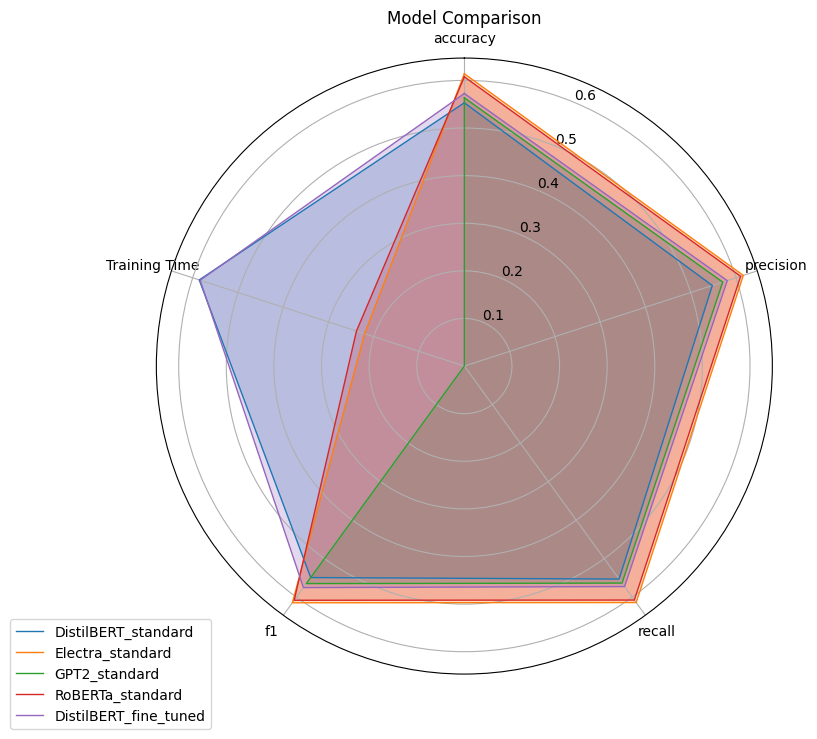

In [22]:
metric_files = [
    "./models/standard/DistilBERT/eval_results.json",
    "./models/standard/Electra/eval_results.json",
    "./models/standard/GPT2/eval_results.json",
    "./models/standard/RoBERTa/eval_results.json",
    "./models/fine_tuned/DistilBERT/eval_results.json"
]

plot_model_comparison(metric_files)

In [23]:
# Predict sentiment using the best model on the test dataset
best_model, best_tokenizer = models[model_name]
best_model_name = model_name

# Predict sentiment using the best model on the test dataset
test_df['predictions'] = test_df['text'].apply(lambda x: predict(best_model, best_tokenizer, x))

# Calculate the accuracy of the best model on the test dataset
accuracy = accuracy_score(test_df['label'], test_df['predictions'])
logger.info(f"Test accuracy of the best model: {accuracy}")

# Generate a classification report for the best model
classification_rep = classification_report(test_df['label'], test_df['predictions'])
logger.info(f"Classification report for the best model:\n{classification_rep}")

# Plot the confusion matrix for the best model
plot_confusion_matrix(test_df['label'], test_df['predictions'], best_model_name)


INFO:httpx:HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"


INFO:Sentiment-Analysis:Test accuracy of the best model: 0.5328
INFO:Sentiment-Analysis:Classification report for the best model:
              precision    recall  f1-score   support

           0       0.68      0.68      0.68       552
           1       0.45      0.47      0.46       509
           2       0.45      0.45      0.45       474
           3       0.47      0.38      0.42       524
           4       0.59      0.70      0.64       441

    accuracy                           0.53      2500
   macro avg       0.53      0.53      0.53      2500
weighted avg       0.53      0.53      0.53      2500

